# FINM 35910 - Homework 2
1. Forumlate Investment Hypothesis and Goals

2. Portfolio Construction and Rebalancing

3. Evaluate Backtesting Results

## Setup

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import time
from datetime import datetime
import pandas_ta as ta
import ccxt
import seaborn as sn
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.insert(0, parent_dir)

from algo_tools import algo_tools as ats

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## Historical data

In [55]:
coinbase = ccxt.coinbase()
reloadedMarkets = coinbase.load_markets(reload=True)

def load_crypto_data(exchange, since, symbol, timeframe):
    data = []
    print(symbol)
    while since < exchange.milliseconds():
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, params={})
            data += ohlcv
            since = max(ohlcv)[0] + 1
            print(pd.to_datetime(since, unit='ms'))
            # time.sleep(1)
        except Exception as e:
            print('Error:', e)
            break
    print('Done')
    
    data = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    data['date'] = pd.to_datetime(data['timestamp'],unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Central').dt.tz_localize(None)
    
    data.set_index('date', inplace=True)
    
    return data

In [ ]:
ds_dict = {}

since = coinbase.parse8601('2023-01-01T00:00:00Z')
# symbols = ['BTC/USDT','ETH/USDT']
symbols = ['ETH/USDT']
# symbol='BTC/USDT'
timeframe = '1m'

for symbol in symbols:
    data = load_crypto_data(exchange=coinbase, since=since, symbol=symbol, timeframe=timeframe)
    ds_dict[symbol] = data

for i in list(ds_dict.keys()):
    ds_dict[i].to_csv(f'./data/{i[:3]}_historical_data_1m.csv')

In [ ]:
btc_df = pd.read_csv(f'./data/BTC_historical_data_1m.csv').set_index('date')
eth_df = pd.read_csv(f'./data/ETH_historical_data_1m.csv').set_index('date')

data = pd.merge(btc_df, eth_df, on='date', suffixes=('_btc', '_eth'))
data.index = pd.to_datetime(data.index)
data = data.sort_index()

data.to_parquet('./data/btc_eth_historical_data_1m.parquet', engine='pyarrow', compression='gzip')
data.loc['2024-01-01':].to_parquet('./data/btc_eth_historical_data_2024_1m.parquet', engine='pyarrow',compression='gzip')

In [362]:
data = pd.read_parquet('./data/btc_eth_historical_data_1m.parquet')
data = data[~data.index.duplicated(keep='last')]
# data = data.groupby(data.index).mean()
# full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='T')
# data = data.reindex(full_index).bfill()
data = data.dropna()

In [363]:
data.head()

,open_btc,high_btc,low_btc,close_btc,volume_btc,open_eth,high_eth,low_eth,close_eth,volume_eth
date,,,,,,,,,,
2021-12-31 18:00:00,46221.22,46257.95,46221.22,46226.81,0.092829,3677.38,3683.82,3677.38,3682.34,5.045412
2021-12-31 18:01:00,46219.13,46311.86,46219.13,46306.76,0.104787,3683.60,3691.11,3683.60,3690.89,3.178447
2021-12-31 18:02:00,46312.41,46375.03,46291.86,46351.02,1.666010,3691.70,3694.29,3687.25,3694.29,5.722987
2021-12-31 18:04:00,46307.73,46307.73,46287.87,46295.59,0.120649,3691.10,3691.52,3689.56,3690.41,4.011082
2021-12-31 18:05:00,46352.42,46447.55,46352.42,46447.55,0.042839,3688.02,3699.28,3688.02,3699.28,0.495793


In [364]:
data.tail()

,open_btc,high_btc,low_btc,close_btc,volume_btc,open_eth,high_eth,low_eth,close_eth,volume_eth
date,,,,,,,,,,
2024-11-13 21:17:00,89627.60,89640.21,89549.81,89603.24,0.576530,3182.31,3183.81,3180.71,3183.79,9.483672
2024-11-13 21:18:00,89537.05,89610.42,89535.00,89610.42,0.323637,3184.40,3187.95,3182.98,3187.95,2.687577
2024-11-13 21:20:00,89742.35,89793.40,89742.35,89793.40,0.084266,3188.40,3193.46,3188.40,3193.29,11.517766
2024-11-13 21:21:00,89806.80,89866.50,89806.80,89863.67,0.395072,3195.52,3198.88,3194.79,3198.88,8.483672
2024-11-13 21:23:00,89916.93,90043.68,89916.93,90043.68,0.673799,3196.71,3205.67,3196.71,3204.84,15.640058


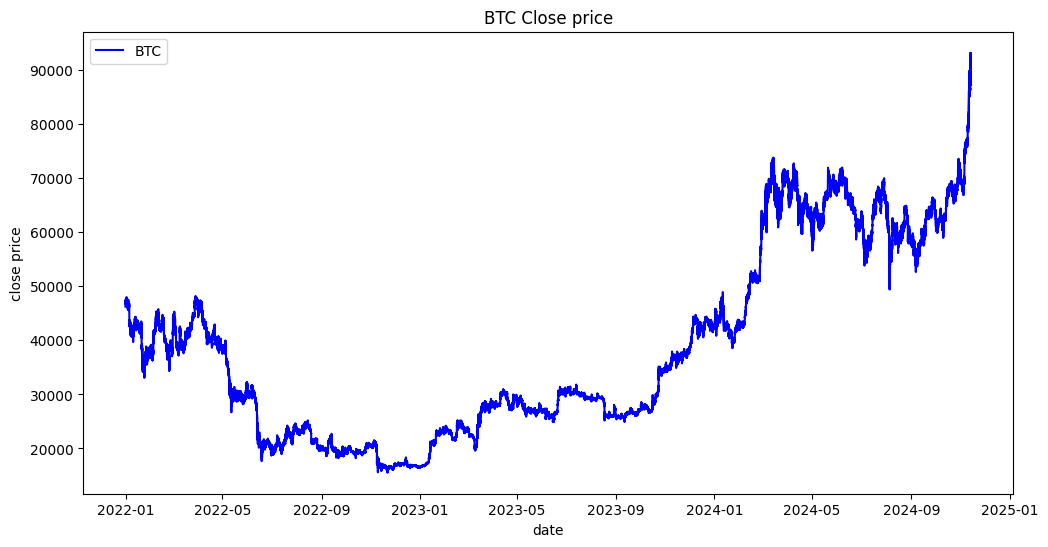

In [365]:
plot_df = data[['close_btc']].copy()
plot_df.columns = ['BTC']
plot_df = plot_df.copy()

plt.figure(figsize=(12,6))
plt.plot(plot_df.index, plot_df['BTC'], label='BTC', color='blue')
# plt.plot(plot_df.index, plot_df['ETH'], label='ETH')
plt.title('BTC Close price')
plt.xlabel('date')
plt.ylabel('close price')
plt.legend()
plt.show()

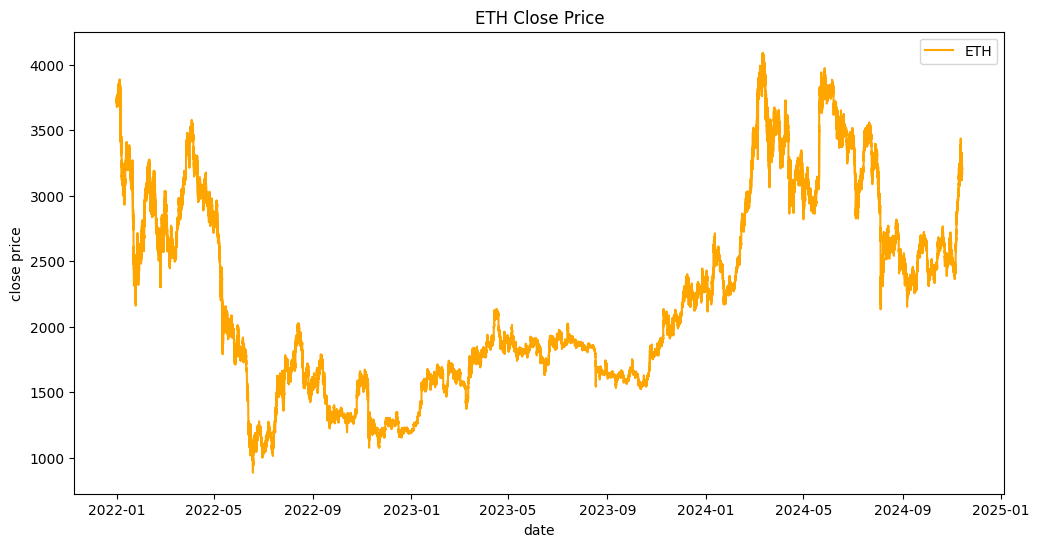

In [366]:
plot_df = data[['close_eth']].copy()
plot_df.columns = ['ETH']
plot_df = plot_df.copy()

plt.figure(figsize=(12,6))
# plt.plot(plot_df.index, plot_df['BTC'], label='BTC')
plt.plot(plot_df.index, plot_df['ETH'], label='ETH', color='orange')
plt.title('ETH Close Price')
plt.xlabel('date')
plt.ylabel('close price')
plt.legend()
plt.show()

In [367]:
print(data.shape)
display(data.head())
display(data.tail())

(834957, 10)


,open_btc,high_btc,low_btc,close_btc,volume_btc,open_eth,high_eth,low_eth,close_eth,volume_eth
date,,,,,,,,,,
2021-12-31 18:00:00,46221.22,46257.95,46221.22,46226.81,0.092829,3677.38,3683.82,3677.38,3682.34,5.045412
2021-12-31 18:01:00,46219.13,46311.86,46219.13,46306.76,0.104787,3683.60,3691.11,3683.60,3690.89,3.178447
2021-12-31 18:02:00,46312.41,46375.03,46291.86,46351.02,1.666010,3691.70,3694.29,3687.25,3694.29,5.722987
2021-12-31 18:04:00,46307.73,46307.73,46287.87,46295.59,0.120649,3691.10,3691.52,3689.56,3690.41,4.011082
2021-12-31 18:05:00,46352.42,46447.55,46352.42,46447.55,0.042839,3688.02,3699.28,3688.02,3699.28,0.495793


,open_btc,high_btc,low_btc,close_btc,volume_btc,open_eth,high_eth,low_eth,close_eth,volume_eth
date,,,,,,,,,,
2024-11-13 21:17:00,89627.60,89640.21,89549.81,89603.24,0.576530,3182.31,3183.81,3180.71,3183.79,9.483672
2024-11-13 21:18:00,89537.05,89610.42,89535.00,89610.42,0.323637,3184.40,3187.95,3182.98,3187.95,2.687577
2024-11-13 21:20:00,89742.35,89793.40,89742.35,89793.40,0.084266,3188.40,3193.46,3188.40,3193.29,11.517766
2024-11-13 21:21:00,89806.80,89866.50,89806.80,89863.67,0.395072,3195.52,3198.88,3194.79,3198.88,8.483672
2024-11-13 21:23:00,89916.93,90043.68,89916.93,90043.68,0.673799,3196.71,3205.67,3196.71,3204.84,15.640058


## Data Preprocessing & Strategy Implementation
- Normalization
- Log Returns
- Stationarity testing

- $ Z = (X-\mu)/\sigma $
    - When z-score is negative (price ratio < mean) ETH is overvalued compared to BTC since price ratio (BTC/ETH) decreased compared to historical average
        - Long BTC / Short ETH
    - When z-score is positive ETH is undervalued compared to BTC
        - Short BTC / Long ETH

Price ratio p-value for Augmented Dickey-Fuller test: 3.58%


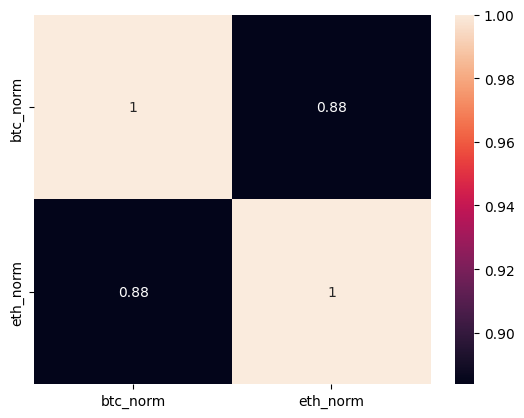

In [368]:
data['btc_norm'] = (data['close_btc'] - data['close_btc'].mean()) / data['close_btc'].std()
data['eth_norm'] = (data['close_eth'] - data['close_eth'].mean()) / data['close_eth'].std()

correlation_matrix = data[['close_btc','close_eth']].copy().corr()
norm_correlation_matrix = data[['btc_norm','eth_norm']].copy().corr()
# sn.heatmap(correlation_matrix, annot=True)
sn.heatmap(norm_correlation_matrix, annot=True)

asset1 = 'btc_norm'
asset2 = 'eth_norm'

test_data = data.loc['2024-10-01':]

result = ts.coint(test_data[asset1], test_data[asset2])

# print(f"p-value for augmented Engle-Granger test: {result[1]}")

# print(f"Asset p-value for Augmented Dickey-Fuller test: {adfuller(test_data[asset2])[1]}")
# print(f"Spread p-value for Augmented Dickey-Fuller test: {adfuller(test_data[asset1] - test_data[asset2])[1]}")
print(f"Price ratio p-value for Augmented Dickey-Fuller test: {adfuller(test_data[asset1]/test_data[asset2])[1]:.2%}")

In [377]:
def pairs_trading_strategy(df, entry_threshold=2, exit_threshold=0.5, rolling_window=60, trading_cost=0.30):
    data = df.copy()
    data['btc_norm'] = (data['close_btc'] - data['close_btc'].mean()) / data['close_btc'].std()
    data['eth_norm'] = (data['close_eth'] - data['close_eth'].mean()) / data['close_eth'].std()
    data['price_ratio'] = data['btc_norm'] / data['eth_norm']

    data['z_score'] = (data['price_ratio'] - data['price_ratio'].rolling(window=rolling_window).mean()) / data['price_ratio'].rolling(window=rolling_window).std()
    
    data['signal'] = 0 
    data.loc[data['z_score'] > entry_threshold, 'signal'] = -1 # Short signal (sell BTC, buy ETH)
    data.loc[data['z_score'] < -entry_threshold, 'signal'] = 1 # Long signal (buy BTC, sell ETH)
    data.loc[data['z_score'].abs() < exit_threshold, 'signal'] = 0 # Exit signal
    data['signal'] = data['signal'].shift(1)

    data['position'] = data['signal'].diff().fillna(0).abs()
    data.loc[data.index[0],'position'] = np.abs(data.loc[data.index[0],'signal'])
    data.loc[data.index[-1],'position'] = np.abs(0 - data.loc[data.index[-1],'signal'])
    
    data['btc_log_return'] = np.log(data['close_btc']/data['close_btc'].shift(1))
    data['eth_log_return'] = np.log(data['close_eth']/data['close_eth'].shift(1))
    
    data['strategy_return'] = data['signal'].shift() * data['btc_log_return'] - data['signal'].shift() * data['eth_log_return']
    data['strategy_return_tc'] = data['strategy_return'] - data['strategy_return']*data['position']*(trading_cost/100)
    return data

In [375]:
import optuna
import numpy as np
import pandas as pd

# Assuming pairs_trading_strategy is already defined
def pairs_trading_strategy(df, entry_threshold=2, exit_threshold=0.5, rolling_window=60):
    data = df.copy()
    data['btc_norm'] = (data['close_btc'] - data['close_btc'].mean()) / data['close_btc'].std()
    data['eth_norm'] = (data['close_eth'] - data['close_eth'].mean()) / data['close_eth'].std()
    data['price_ratio'] = data['btc_norm'] / data['eth_norm']
    
    data['z_score'] = (data['price_ratio'] - data['price_ratio'].rolling(window=rolling_window).mean()) / data['price_ratio'].rolling(window=rolling_window).std()
    
    data['signal'] = 0 
    data.loc[data['z_score'] > entry_threshold, 'signal'] = -1 # Short signal (sell BTC, buy ETH)
    data.loc[data['z_score'] < -entry_threshold, 'signal'] = 1 # Long signal (buy BTC, sell ETH)
    data.loc[data['z_score'].abs() < exit_threshold, 'signal'] = 0 # Exit signal
    data['signal'] = data['signal'].shift(1)
    
    data['btc_log_return'] = np.log(data['close_btc'] / data['close_btc'].shift(1))
    data['eth_log_return'] = np.log(data['close_eth'] / data['close_eth'].shift(1))
    
    # Calculate strategy returns
    data['strategy_return'] = data['signal'].shift() * data['btc_log_return'] - data['signal'].shift() * data['eth_log_return']
    
    # Return cumulative return as the objective
    data['cumulative_return'] = data['strategy_return'].cumsum().apply(np.exp)-1
    final_result = data['cumulative_return'].iloc[-1]
    return final_result # Cumulative return at the end

# Objective function for Optuna optimization
def objective(trial):
    # Suggest values for the hyperparameters within the defined ranges
    entry_threshold = trial.suggest_float('entry_threshold', 1.0, 3.0)  # Range between 1 and 3
    exit_threshold = trial.suggest_float('exit_threshold', 0.2, 1)   # Range between 0.2 and 1
    rolling_window = trial.suggest_int('rolling_window', 10, 200)  # Range between 20 and 100
    
    # Example data (replace with your actual data)
    start_date = '2023-01-01'
    optuna_data = pd.DataFrame({
        'close_btc': data.loc[start_date:,'close_btc'],  # Replace with actual BTC closing prices
        'close_eth': data.loc[start_date:,'close_eth'],  # Replace with actual ETH closing prices
    })
    
    # Run the pairs trading strategy and get the cumulative return
    return pairs_trading_strategy(optuna_data, entry_threshold, exit_threshold, rolling_window)

# Create an Optuna study to optimize the objective function
study = optuna.create_study(direction='maximize')  # We want to maximize the cumulative return

# Optimize the study for 100 trials (you can change the number of trials based on your needs)
study.optimize(objective, n_trials=100)

# Output the best trial and parameters
print(f"Best trial number: {study.best_trial.number}")
print(f"Best parameters: {study.best_trial.params}")
print(f"Best cumulative return: {study.best_value}")

[I 2024-11-15 11:36:26,803] A new study created in memory with name: no-name-a308cae0-3c45-4b74-b999-3a6f22b4451e
[I 2024-11-15 11:36:26,942] Trial 0 finished with value: -0.24410998866764932 and parameters: {'entry_threshold': 2.3240559949903465, 'exit_threshold': 0.844851682662636, 'rolling_window': 78}. Best is trial 0 with value: -0.24410998866764932.
[I 2024-11-15 11:36:27,053] Trial 1 finished with value: -0.28948754283512346 and parameters: {'entry_threshold': 2.3882446259904917, 'exit_threshold': 0.9196358749476496, 'rolling_window': 31}. Best is trial 0 with value: -0.24410998866764932.
[I 2024-11-15 11:36:27,169] Trial 2 finished with value: -0.39081739356846856 and parameters: {'entry_threshold': 1.4626103127772023, 'exit_threshold': 0.5036641940023319, 'rolling_window': 60}. Best is trial 0 with value: -0.24410998866764932.
[I 2024-11-15 11:36:27,277] Trial 3 finished with value: -0.18119704298821937 and parameters: {'entry_threshold': 2.978908420738077, 'exit_threshold': 0

Best trial number: 86
Best parameters: {'entry_threshold': 1.056811720353562, 'exit_threshold': 0.313164213864446, 'rolling_window': 137}
Best cumulative return: 0.1767353044018214


Strategy cumulative return: -0.046025292960925834


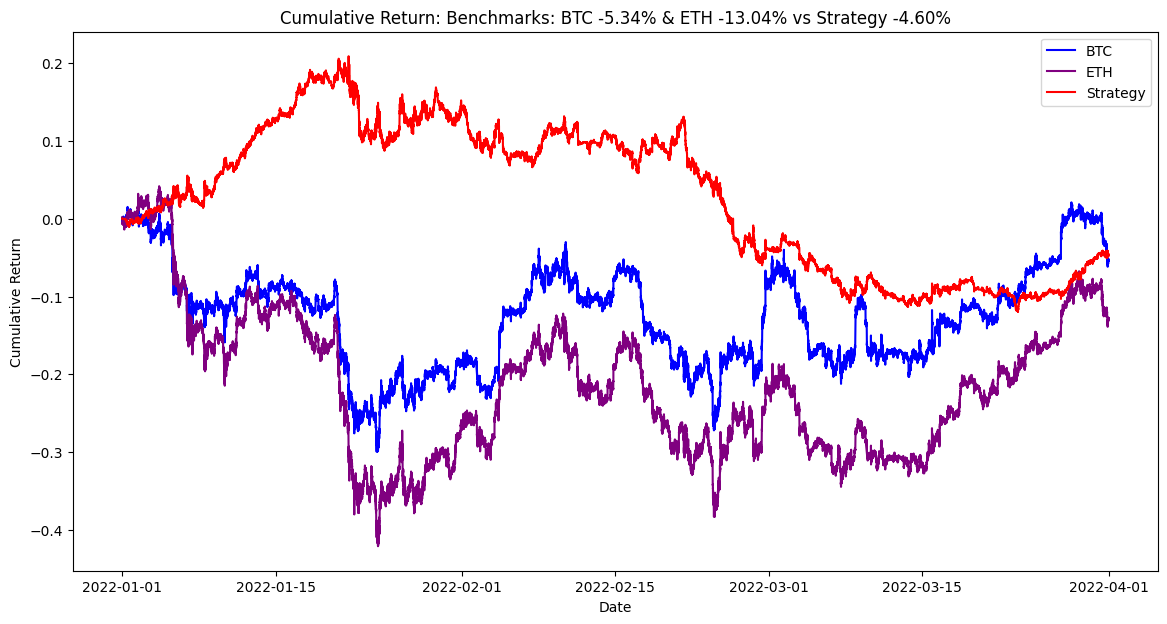

Strategy cumulative return: 0.18938475139984412


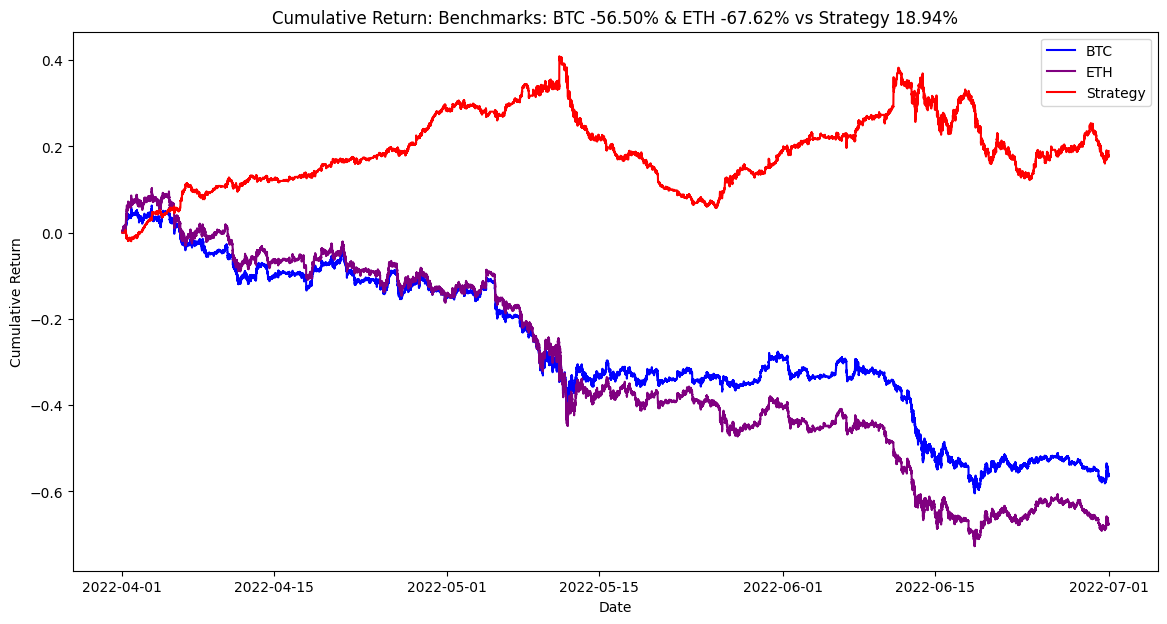

Strategy cumulative return: -0.3162679498936223


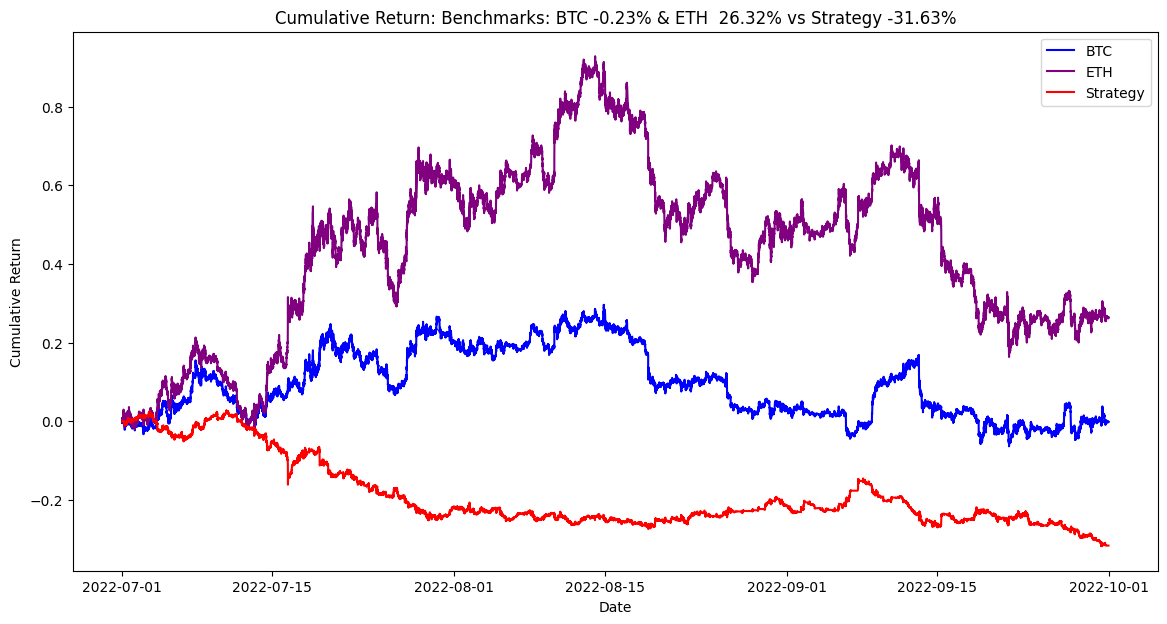

Strategy cumulative return: -0.16531070277906412


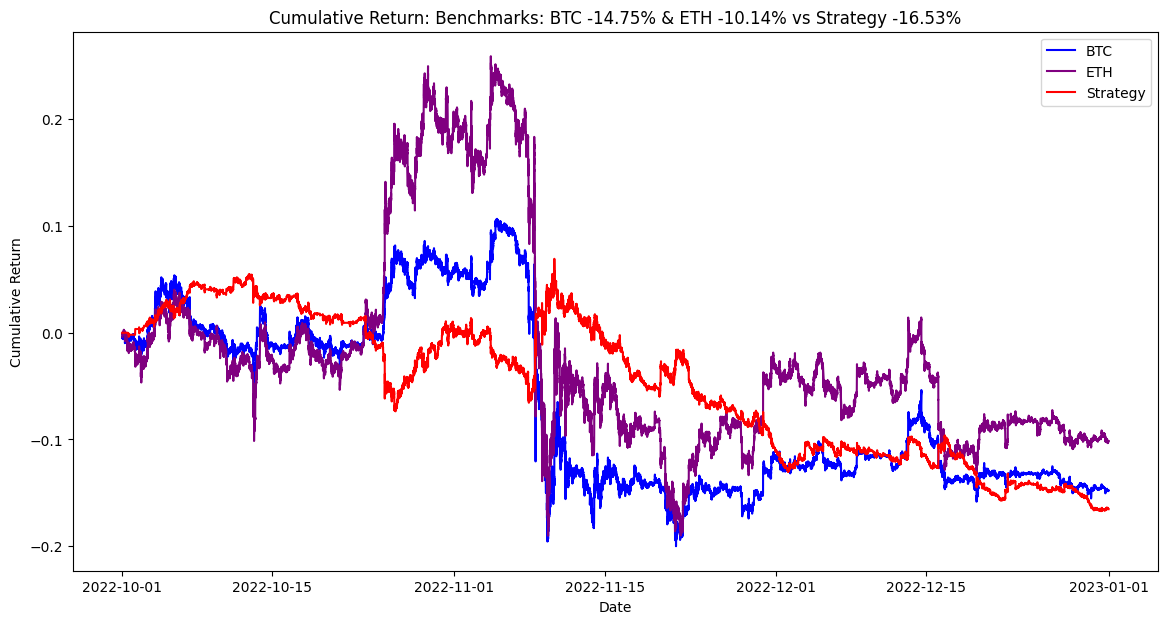

Strategy cumulative return: -0.18987217791567057


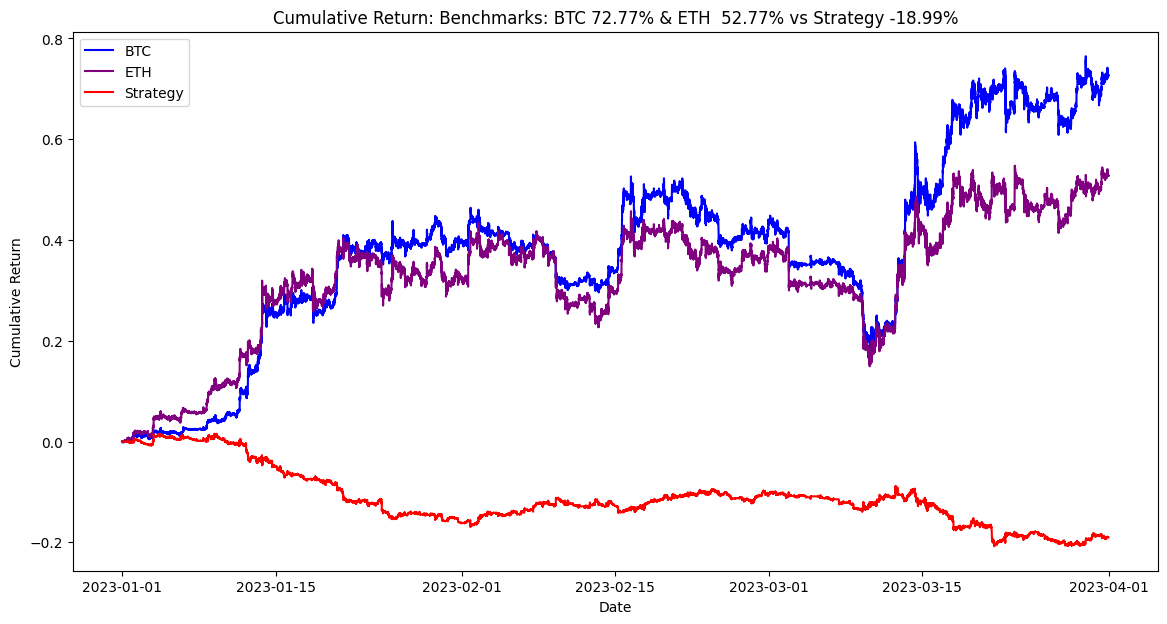

Strategy cumulative return: -0.1483309708446725


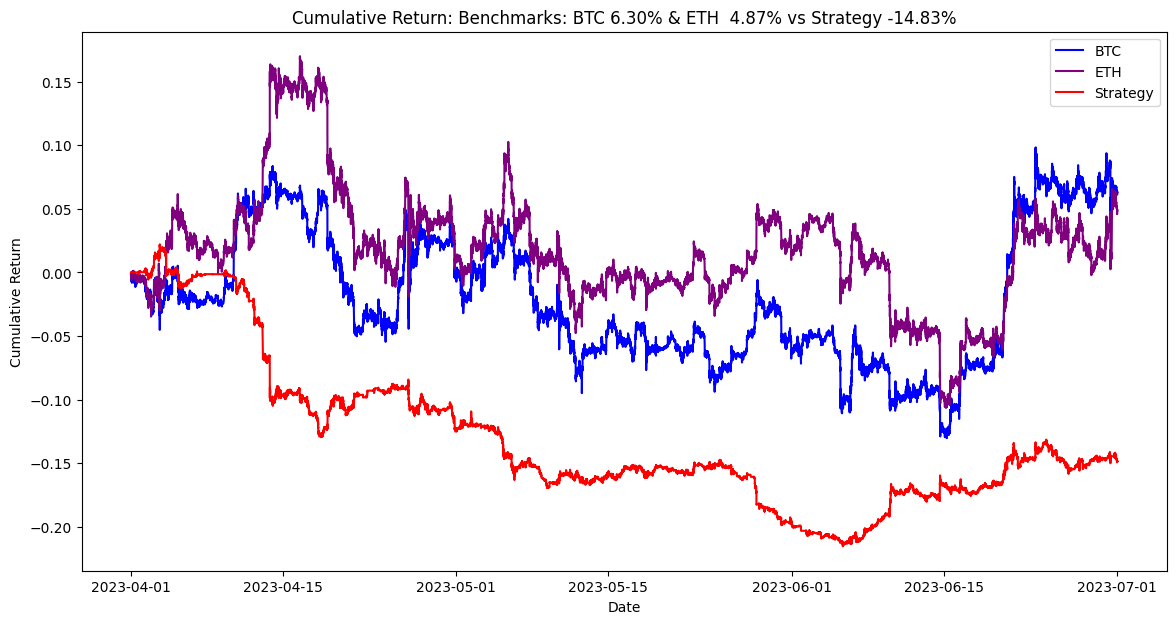

Strategy cumulative return: 0.10188995826597957


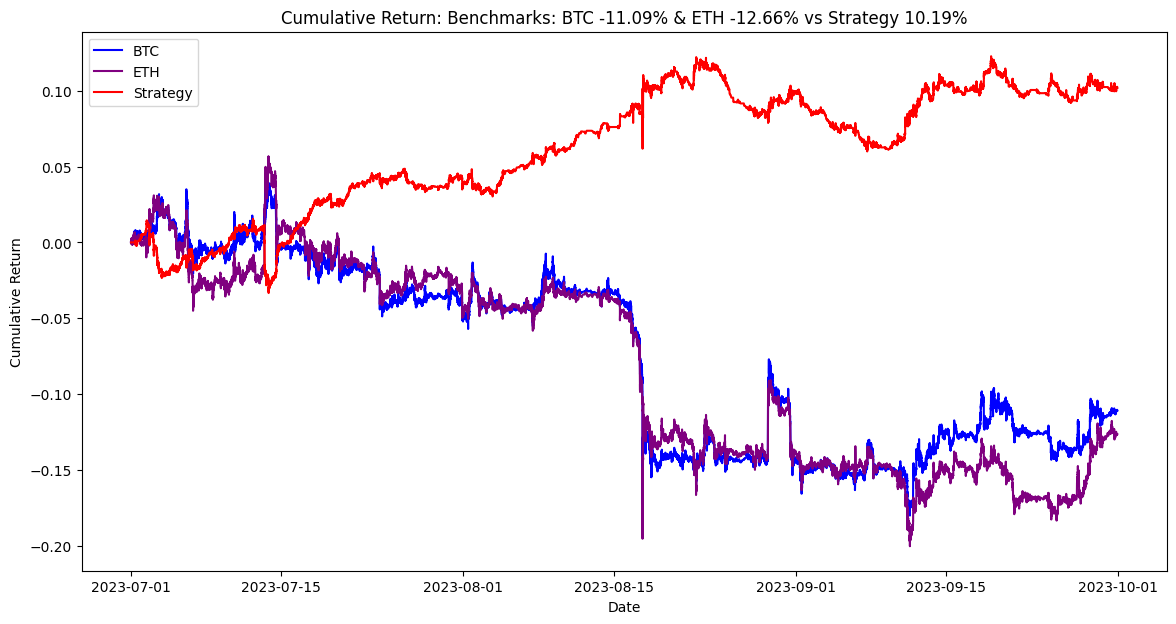

Strategy cumulative return: 0.11287249003973487


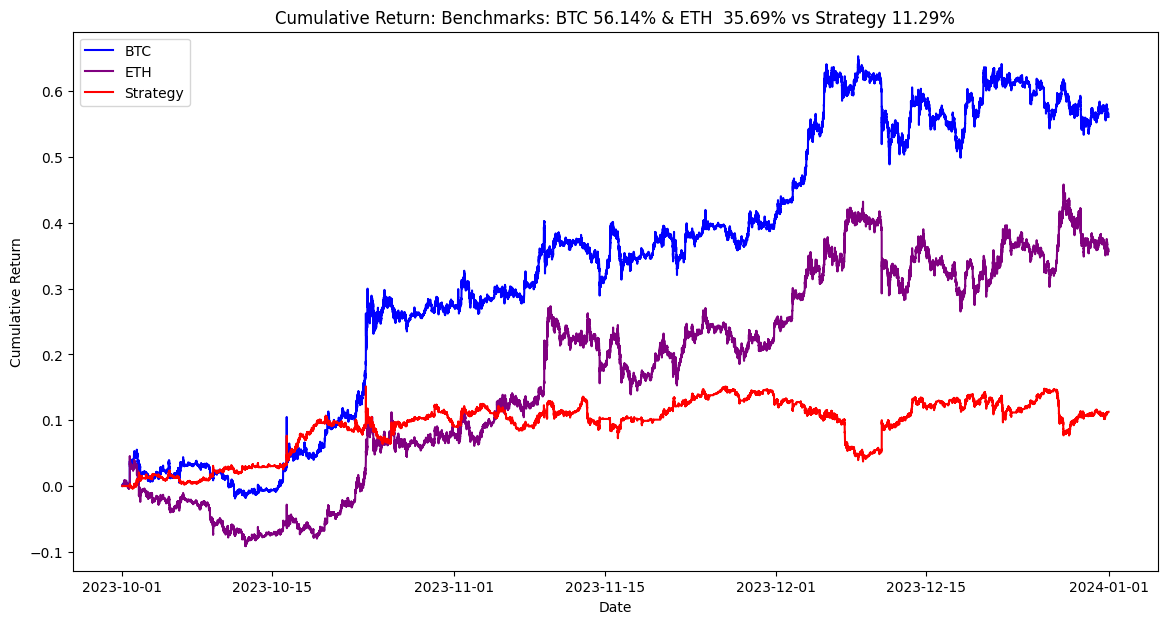

Strategy cumulative return: 0.01892006350994424


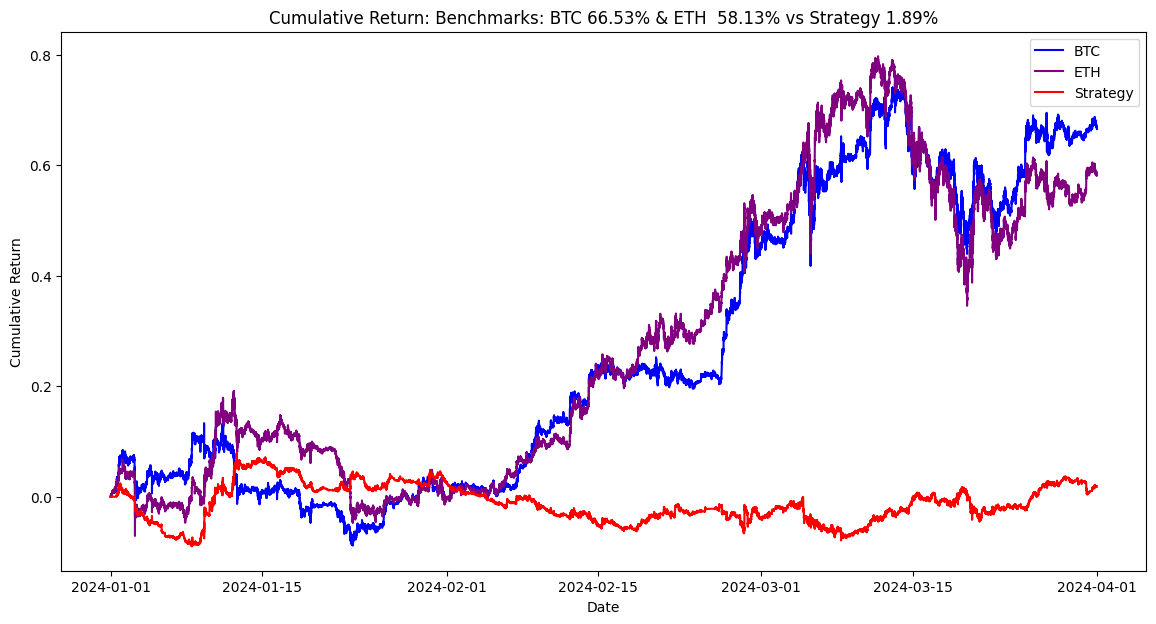

Strategy cumulative return: -0.07127395080646448


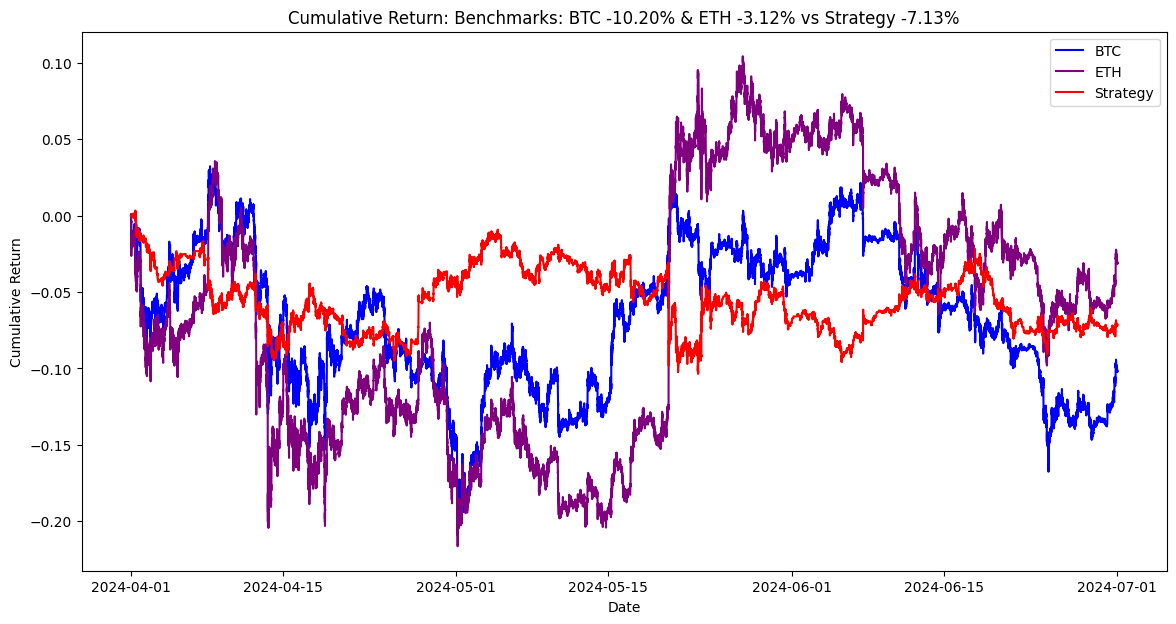

Strategy cumulative return: 0.08164326765931995


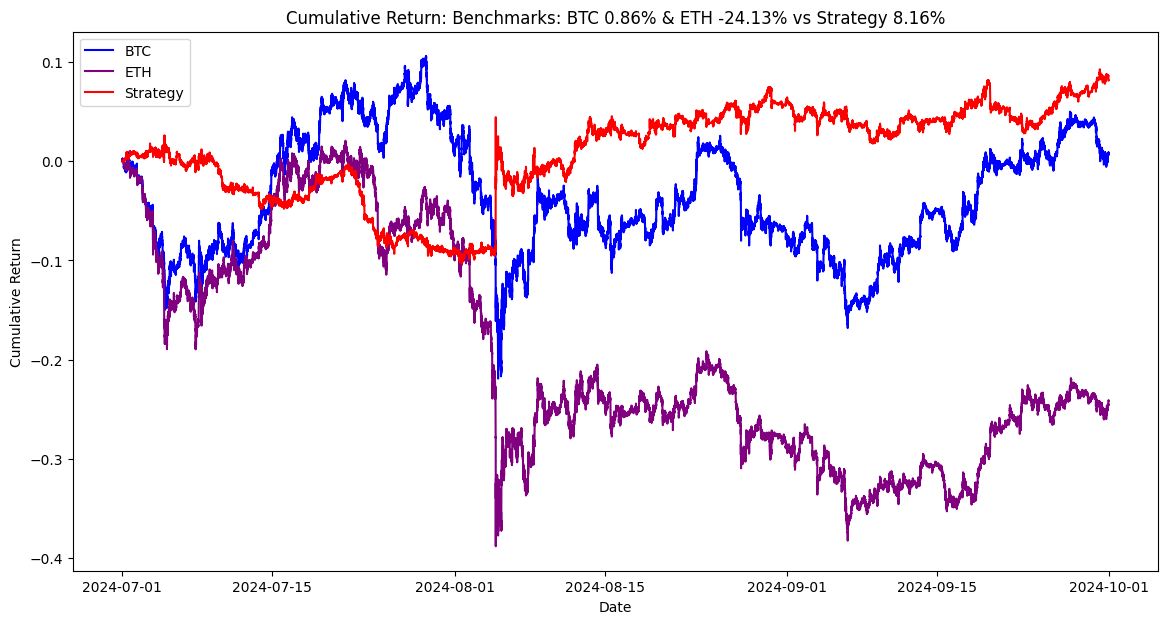

Strategy cumulative return: 0.8419664224019712


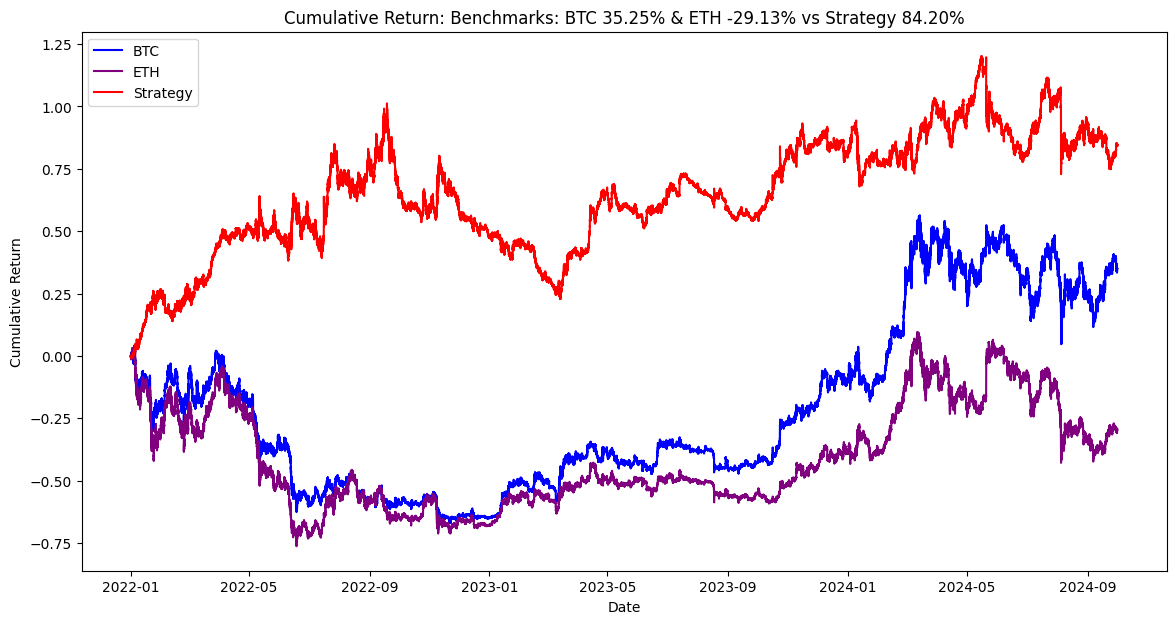

In [411]:
# Best parameters: {'entry_threshold': 1.0412046076288992, 'exit_threshold': 0.27043047652464947, 'rolling_window': 187}
# Best cumulative return: 0.7575809000595151

# Best parameters: {'entry_threshold': 1.1168824356922697, 'exit_threshold': 0.3174327081743927, 'rolling_window': 148}
# Best cumulative return: 0.17917225477292642

for date in [
    data.loc['2022-01-01':'2022-03-31'], 
    data.loc['2022-04-01':'2022-06-30'], 
    data.loc['2022-07-01':'2022-09-30'], 
    data.loc['2022-10-01':'2022-12-31'],
    data.loc['2023-01-01':'2023-03-31'],
    data.loc['2023-04-01':'2023-06-30'],
    data.loc['2023-07-01':'2023-09-30'],
    data.loc['2023-10-01':'2023-12-31'],
    data.loc['2024-01-01':'2024-03-31'],
    data.loc['2024-04-01':'2024-06-30'],
    data.loc['2024-07-01':'2024-09-30'],
    data.loc['2022-01-01':'2024-09-30']
]:
    back_test = pairs_trading_strategy(date, 
                                    entry_threshold=1.0, 
                                    exit_threshold=0.6, 
                                    rolling_window=150).copy()

    back_test['strategy_cumulative_return'] = back_test['strategy_return'].cumsum().apply(np.exp)-1
    back_test['strategy_cumulative_return_tc'] = back_test['strategy_return_tc'].cumsum().apply(np.exp)-1
    back_test['btc_cumulative_return'] = back_test['btc_log_return'].cumsum().apply(np.exp)-1
    back_test['eth_cumulative_return'] = back_test['eth_log_return'].cumsum().apply(np.exp)-1

    print(f"Strategy cumulative return: {back_test['strategy_cumulative_return_tc'].iloc[-1]}")

    plot_df = back_test[['btc_cumulative_return','eth_cumulative_return','strategy_cumulative_return_tc']].copy()
    plot_df.columns = ['BTC','ETH','Strategy']
    plot_df = plot_df.copy()
    strat_return = back_test['strategy_cumulative_return_tc'].iloc[-1]
    btc_return = back_test['btc_cumulative_return'].iloc[-1]
    eth_return = back_test['eth_cumulative_return'].iloc[-1]

    plt.figure(figsize=(14,7))
    plt.plot(plot_df.index, plot_df['BTC'], label='BTC', color='blue')
    plt.plot(plot_df.index, plot_df['ETH'], label='ETH', color='purple')
    plt.plot(plot_df.index, plot_df['Strategy'], label='Strategy', color='red')
    plt.title(f"Cumulative Return: Benchmarks: BTC {btc_return:.2%} & ETH {eth_return: .2%} vs Strategy {strat_return:.2%}")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

In [ ]:
back_test.loc[back_test]

In [452]:
back_test.signal.value_counts().to_frame('Number of Transactions')

,Number of Transactions
signal,
0.0,393811
-1.0,204301
1.0,203370


In [ ]:
benchmark=back_test['btc_log_return'].to_frame('BTC Risk Metrics').dropna()
strategy=back_test['strategy_return_tc'].to_frame('Strategy Risk Metrics').dropna()

strategy_risk_metrics = ats.calc_risk_metrics(
                    strategy,
                    benchmark,
                    as_df=True,
                    adj=60*24*365)

btc_risk_metrics = ats.calc_risk_metrics(
                    benchmark,
                    benchmark,
                    as_df=True,
                    adj=60*24*365)

performance_metrics = pd.concat([strategy_risk_metrics, btc_risk_metrics], axis=0).fillna(0)



performance_metrics[['VaR (0.05)', 'CVaR (0.05)', 'Min', 'Max',
       'Tracking Error', 'Information Ratio', 'Max Drawdown']]

,VaR (0.05),CVaR (0.05),Min,Max,Tracking Error,Information Ratio,Max Drawdown
Strategy Risk Metrics,-0.000922,-0.001602,-0.059253,0.043257,0.889937,0.227282,-0.406525
BTC Risk Metrics,-0.001487,-0.002393,-0.044797,0.045741,0.000000,0.000000,-0.739485


In [449]:
performance_metrics.columns

Index(['Mean', 'Volatility', 'Sharpe Ratio', 'Sortino Ratio', 'Skewness',
       'Excess Kurtosis', 'VaR (0.05)', 'CVaR (0.05)', 'Min', 'Max',
       'Tracking Error', 'Information Ratio', 'Max Drawdown'],
      dtype='object')

In [433]:
te = pd.concat([benchmark, strategy], axis=1).dropna()
te = te.iloc[:,1] - te.iloc[:,0]
te.values.reshape(-1,1).mean()*(60*24*365)

0.20226664762931448

In [436]:
(te.values.reshape(-1,1).mean()*(60*24*365)).std()

0.0

In [444]:
import sys

def forget_module(module_name):
    if module_name in sys.modules:
        del sys.modules[module_name]
        print(f"Module '{module_name}' has been forgotten (removed from sys.modules).")
        return True
    else:
        print(f"Module '{module_name}' is not currently loaded.")
        return False
    
forget_module('algo_tools') 


from algo_tools import algo_tools as ats

Module 'algo_tools' has been forgotten (removed from sys.modules).
